## Demo Randomized Smoothing

First, we load the base classifier and load the weight.

In [1]:
import torch
import time
from scipy.stats import norm, binomtest
import numpy as np
from math import ceil
from statsmodels.stats.proportion import proportion_confint
from architectures import get_architecture
from datasets import get_dataset, DATASETS, get_num_classes
import matplotlib.pyplot as plt

# fix seeds
seed = 777
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# load base classifier
baseClassifierPath = '../models/cifar10/resnet110/noise_0.12/checkpoint.pth.tar'
checkpoint = torch.load(baseClassifierPath)
base_classifier = get_architecture(checkpoint["arch"], 'cifar10')
base_classifier.load_state_dict(checkpoint['state_dict'])
# base_classifier.eval()


<All keys matched successfully>

### Randomized Smoothing Implementation

In [2]:
class Smooth(object):
    """A smoothed classifier g """
    ABSTAIN = -1

    def __init__(self, base_classifier: torch.nn.Module, num_classes: int, sigma: float):
        self.base_classifier = base_classifier
        self.num_classes = num_classes
        self.sigma = sigma

    def certify(self, x: torch.tensor, n0: int, n: int, alpha: float, batch_size: int):
        self.base_classifier.eval()
        counts_selection = self._sample_noise(x, n0, batch_size)
        cAHat = counts_selection.argmax().item()
        counts_estimation = self._sample_noise(x, n, batch_size)
        nA = counts_estimation[cAHat].item()
        pABar = self._lower_confidence_bound(nA, n, alpha)
        if pABar < 0.5:
            return Smooth.ABSTAIN, 0.0
        else:
            radius = self.sigma * norm.ppf(pABar)
            return cAHat, radius

    def _sample_noise(self, x: torch.tensor, num: int, batch_size) -> np.ndarray:
        with torch.no_grad():
            counts = np.zeros(self.num_classes, dtype=int)
            for _ in range(ceil(num / batch_size)):
                this_batch_size = min(batch_size, num)
                num -= this_batch_size
                batch = x.repeat((this_batch_size, 1, 1, 1))
                noise = torch.randn_like(batch, device='cuda') * self.sigma
                predictions = self.base_classifier(batch + noise).argmax(1)
                counts += self._count_arr(predictions.cpu().numpy(), self.num_classes)
            return counts

    def _count_arr(self, arr: np.ndarray, length: int) -> np.ndarray:
        counts = np.zeros(length, dtype=int)
        for idx in arr:
            counts[idx] += 1
        return counts

    def _lower_confidence_bound(self, NA: int, N: int, alpha: float) -> float:
        return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
    
    def predict(self, x: torch.tensor, n: int, alpha: float, batch_size: int) -> int:
        self.base_classifier.eval()
        counts = self._sample_noise(x, n, batch_size)
        top2 = counts.argsort()[::-1][:2]
        count1 = counts[top2[0]]
        count2 = counts[top2[1]]
        if binomtest(count1, count1 + count2, p=0.5).pvalue > alpha:
            return Smooth.ABSTAIN
        else:
            return top2[0]

# create the smooothed classifier g
smoothed_classifier = Smooth(base_classifier, 10, sigma=0.12)
# create the dataset
dataset = get_dataset('cifar10', 'test')


Files already downloaded and verified


### Let's Test It!

Prediction: 1
Ground Truth: 1
Time: 3.707
Radius: 0.457
Attacking.. 1000/1000
Test result: {1: 1000}
Success rate: 0.00%


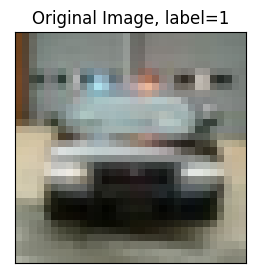

In [3]:
(x, label) = dataset[66]

plt.figure(figsize=(3,3))
plt.imshow(x.permute(1, 2, 0), )
plt.xticks([])
plt.yticks([])
plt.title(f'Original Image, label={label}' )

before_time = time.time()
x = x.cuda()
prediction, radius = smoothed_classifier.certify(x, n0=100, n=100000, alpha=0.001, batch_size=1024)
after_time = time.time()
correct = 'correct' if prediction == label else 'incorrect'

print(f'Prediction: {prediction}\nGround Truth: {label}\nTime: {after_time - before_time:.3f}')
print(f'Radius: {radius:.3f}')

result = []
for _ in range(1000):
    print(f'Attacking.. {_+1}/1000', end='\r')
    noise = torch.randn_like(x, device='cuda')
    noise = noise / torch.norm(noise, p=2) * radius
    perturbed_image = x + noise
    prediction = smoothed_classifier.predict(perturbed_image, n=100, alpha=0.001, batch_size=100)
    result.append(prediction)
    
count = np.unique(result, return_counts=True)
count = dict(zip(count[0], count[1]))
print()
print('Test result:', count)
print('Success rate:', f'{(1-count[label]/1000)*100:.2f}%')


Prediction: 7
Ground Truth: 7
Time: 3.615
Radius: 0.438
Test result: {7: 1000}
Success rate: 0.00%


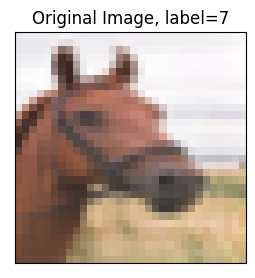

In [4]:
(x, label) = dataset[99]

plt.figure(figsize=(3,3))
plt.imshow(x.permute(1, 2, 0), )
plt.xticks([])
plt.yticks([])
plt.title(f'Original Image, label={label}' )

before_time = time.time()
x = x.cuda()
prediction, radius = smoothed_classifier.certify(x, n0=100, n=100000, alpha=0.001, batch_size=1024)
after_time = time.time()
correct = 'correct' if prediction == label else 'incorrect'

print(f'Prediction: {prediction}\nGround Truth: {label}\nTime: {after_time - before_time:.3f}')
print(f'Radius: {radius:.3f}')

result = []
for _ in range(1000):
    print(f'Attacking.. {_+1}/1000', end='\r')
    noise = torch.randn_like(x, device='cuda')
    noise = noise / torch.norm(noise, p=2) * radius
    perturbed_image = x + noise
    prediction = smoothed_classifier.predict(perturbed_image, n=100, alpha=0.001, batch_size=100)
    result.append(prediction)
    
count = np.unique(result, return_counts=True)
count = dict(zip(count[0], count[1]))
print('Test result:', count)
print('Success rate:', f'{(1-count[label]/1000)*100:.2f}%')

In [10]:
result = []
for _ in range(1000):
    print(f'Attacking.. {_+1}/1000', end='\r')
    noise = torch.randn_like(x, device='cuda')
    noise = noise / torch.norm(noise, p=2) * radius * 20
    perturbed_image = x + noise
    prediction = smoothed_classifier.predict(perturbed_image, n=100, alpha=0.001, batch_size=100)
    result.append(prediction)
    
count = np.unique(result, return_counts=True)
count = dict(zip(count[0], count[1]))
print('\nTest result:', count)
print('Success rate:', f'{(1-count[label]/1000)*100:.2f}%')

Attacking.. 1000/1000
Test result: {-1: 26, 7: 973, 9: 1}
Success rate: 2.70%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original Image, label=7')

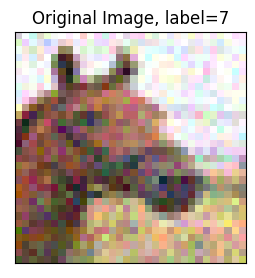

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(perturbed_image.cpu().permute(1, 2, 0), )
plt.xticks([])
plt.yticks([])
plt.title(f'Original Image, label={label}' )